In [49]:
!pip install -q plot_utils

In [50]:
import tensorflow as tf
import numpy as np
import PIL
import os
import time
import glob
import imageio
import plot_utils
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython import display
from tensorflow.keras import layers
%matplotlib inline

In [51]:
(train_images, train_labels), (_,_) = tf.keras.datasets.fashion_mnist.load_data()


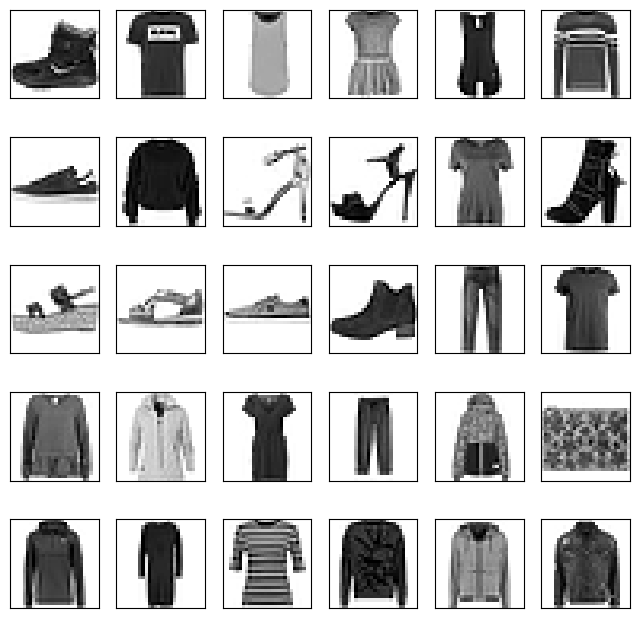

In [52]:
plt.figure(figsize=(8,8))
for i in range(30):
  plt.subplot(5,6, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(train_images[i], cmap=plt.cm.binary)

plt.show()

In [53]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 # Normalize the images to [-1, 1]

In [54]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [55]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [56]:
train_images.shape

(60000, 28, 28, 1)

In [57]:
def make_discriminator_model():
  model = tf.keras.Sequential()
  model.add(layers.Conv2D(64, (5,5), strides=(2,2), padding='same', input_shape=[28, 28, 1]))
  model.add(layers.LeakyReLU(0.2))
  model.add(layers.Dropout(0.3))
  model.add(layers.Conv2D(128, (5,5), strides=(2,2), padding='same'))
  model.add(layers.LeakyReLU(0.2))
  model.add(layers.Dropout(0.3))
  model.add(layers.Flatten())
  model.add(layers.Dense(2))
  return model


In [58]:
num_features = 100 #number of dimensions of the input latent variable space(noise)
def make_generator_model():
  model = tf.keras.Sequential()
  model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())
  model.add(layers.Reshape([7, 7, 256]))
  model.add(layers.Conv2DTranspose(64, (5,5), strides=(2,2), padding='same', use_bias=False ,activation='selu'))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())
  model.add(layers.Conv2DTranspose(1, (5,5), strides=(2,2), padding='same', use_bias=False ,activation='tanh'))
  return model

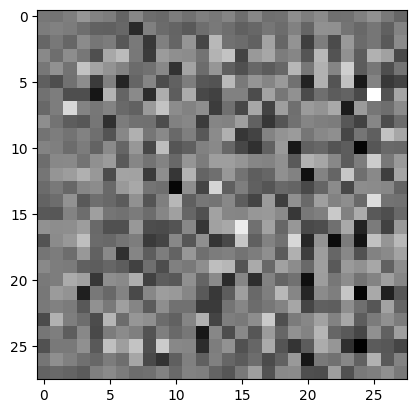

In [59]:
generator = make_generator_model()
noise = tf.random.normal([1,100])
generated_image = generator(noise, training=False)
plt.imshow(generated_image[0, :, :, 0], cmap='gray')
plt.show()

In [60]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[0.0024368  0.00372015]], shape=(1, 2), dtype=float32)


In [61]:
cross_entropy = tf.keras.losses.CategoricalCrossentropy(from_logits=True)


In [62]:
def discriminator_loss(real_output, fake_output):
  real_loss = cross_entropy(tf.ones_like(real_output), real_output)
  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)

  return real_loss + fake_loss

In [63]:
def generator_loss(fake_output):
  return cross_entropy(tf.ones_like(fake_output), fake_output)


In [64]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(0.0001)

In [65]:
checkpoint_dir = '/content/drive/MyDrive/training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [66]:
EPOCHS = 60
noise_dim = 100
num_example_to_generate = 16

seed = tf.random.normal([num_example_to_generate, noise_dim])

In [67]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [68]:
def generate_and_save_images(model, epoch, test_input):
  pred = model(test_input, training=False)
  fig = plt.figure(figsize=(4,4))

  for i in range(pred.shape[0]):
    plt.subplot(4, 4, i+1)
    plt.imshow(pred[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
    plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [69]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix=checkpoint_prefix)
    print('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

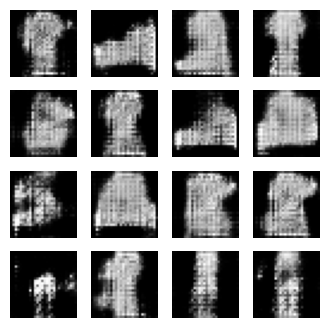

In [70]:
train(train_dataset, EPOCHS)

In [71]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [72]:
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

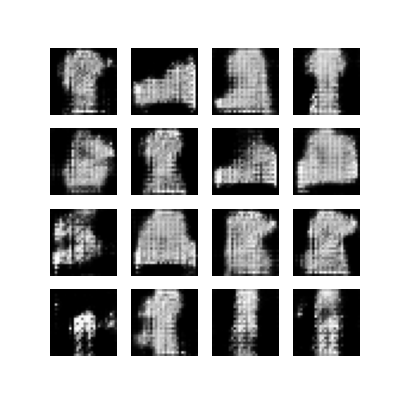

In [73]:
display_image(EPOCHS)

In [74]:
anime_file = 'mnist_gan.gif'

with imageio.get_writer(anime_file, model='I') as writer:
  file_names = glob.glob('image*.png')
  file_names = sorted(file_names)
  for file_name in file_names:
    image = imageio.imread(file_name)
    writer.append_data(image)

  image = imageio.imread(file_name)
  writer.append_data(image)

<ipython-input-74-8be6bca68a94>:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(file_name)
<ipython-input-74-8be6bca68a94>:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(file_name)
